In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

In [2]:
import h5py
import numpy as np
import scipy as sp
import scipy.stats as stats
import nibabel as nibabel
import pandas as pd
import nibabel.freesurfer.mghformat as mgh
import scipy.io
import itertools 
import pickle

In [3]:
data_dir = '../../../data/'

In [4]:
subjid = ['01', '02', '03', '04', '05', '06', '07', '08']
ROI_names = ['Unknown', 'Early', 'Midventral', 'Midlateral', 'Midparietal', 'Ventral', 'Lateral', 'Parietal']
n_repeats = 3

In [5]:
##FOR THRESH
#threshold for voxels (based on split-half reliability)
thresh = 0.2

In [6]:
with open('rh_betas_by_repeat_by_ROI_zscore.data', 'rb') as filehandle:
    # read the data as binary data stream
    rh_betas_by_repeat_by_ROI = pickle.load(filehandle)

In [7]:
##FOR THRESH
reliability = []
for sidx, sid in enumerate(subjid):
    
    sh_dir = '../../../local_data/freesurfer/subj' + sid + '/rh_split_half.mat'
    sh = scipy.io.loadmat(sh_dir)
    
    reliability.append(sh['mean'])

In [8]:
##FOR THRESH
rh_streams = []
for sidx, sid in enumerate(subjid):
    mgh_file = mgh.load(data_dir+'nsddata/freesurfer/subj'+ sid +'/label/rh.streams.mgz')
    rh_streams.append(mgh_file.get_fdata()[:,0,0])

In [9]:
##FOR THRESH
# let's organize by ROI 
sh_by_ROI = [[[] for j in range(len(ROI_names)-1)] for i in range(len(subjid))]
total_vox = np.zeros((len(subjid), len(ROI_names)-1))

for sidx, sid in enumerate(subjid):  
    for roi_idx in range(len(ROI_names)-1):       
        sh_by_ROI[sidx][roi_idx]=reliability[sidx][:,rh_streams[sidx] == roi_idx+1]
        total_vox[sidx,roi_idx] = len(sh_by_ROI[sidx][roi_idx][0])

In [10]:
##FOR THRESH
for sidx, sid in enumerate(subjid):  
    for roi_idx in range(len(ROI_names)-1): 
        for vox in range(len(sh_by_ROI[sidx][roi_idx][0])):
            if sh_by_ROI[sidx][roi_idx][0][vox] < thresh:
                rh_betas_by_repeat_by_ROI[sidx][roi_idx][0][:,vox]=np.nan
                rh_betas_by_repeat_by_ROI[sidx][roi_idx][1][:,vox]=np.nan
                rh_betas_by_repeat_by_ROI[sidx][roi_idx][2][:,vox]=np.nan     

In [11]:
##FOR THRESH
#trim out nans
thresh_vox = np.zeros((len(subjid), len(ROI_names)-1))

for sidx, sid in enumerate(subjid):  
    for roi_idx in range(len(ROI_names)-1): 
        for r in range(n_repeats):
            temp = rh_betas_by_repeat_by_ROI[sidx][roi_idx][r]
            trimmed = temp[:,~np.all(np.isnan(temp), axis=0)]

            rh_betas_by_repeat_by_ROI[sidx][roi_idx][r] = trimmed
        thresh_vox[sidx,roi_idx] = trimmed.shape[1]
        

In [12]:
vox = np.zeros((len(ROI_names)-1, len(subjid)))

for roi_idx in range(len(ROI_names)-1):
    vox[roi_idx,:] = [rh_betas_by_repeat_by_ROI[sidx][roi_idx][0].shape[1] for sidx, sid in enumerate(subjid)]

In [13]:
#Create RSMS

tril_flat_shape = int((rh_betas_by_repeat_by_ROI[0][0][0].shape[0]**2/2) - (rh_betas_by_repeat_by_ROI[0][0][0].shape[0]/2))
flat_rsm = np.zeros((len(subjid),len(ROI_names)-1, tril_flat_shape, n_repeats))
rsm = np.zeros((len(subjid),len(ROI_names)-1,n_repeats,rh_betas_by_repeat_by_ROI[0][0][0].shape[0],rh_betas_by_repeat_by_ROI[0][0][0].shape[0]))

for sidx, sid in enumerate(subjid):
    
    for roi_idx in range(len(ROI_names)-1):
        voxels = np.min(vox[roi_idx,:])
        
        for r in range(n_repeats):
            
            #ONLY USING THE LOWEST NUM VOXELS FOR EACH ROI ACROSS SUBJ
            #rsm[sidx,roi_idx,r,:,:] = np.corrcoef(rh_betas_by_repeat_by_ROI[sidx][roi_idx][r][:,0:int(voxels)])
            rsm[sidx,roi_idx,r,:,:] = np.corrcoef(rh_betas_by_repeat_by_ROI[sidx][roi_idx][r])

            lower = np.tril(rsm[sidx,roi_idx,r,:,:], -1).T.ravel()

            flat_rsm[sidx, roi_idx, :,r] = lower[lower != 0]

In [14]:
flat_rsm.shape

(8, 7, 132355, 3)

In [15]:
roi_idx = np.arange(0,len(ROI_names)-1) #-1 because we've removed "unknown"
roi_combs = list(itertools.combinations(roi_idx, 2))

r1_trial_order = [0, 0, 0, 1, 1, 1, 2, 2, 2]
r2_trial_order = [0, 1, 2, 0, 1, 2, 0, 1, 2]

print(roi_combs)

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 3), (2, 4), (2, 5), (2, 6), (3, 4), (3, 5), (3, 6), (4, 5), (4, 6), (5, 6)]


In [16]:
subj_idx = np.arange(0,len(subjid))
subj_combs = list(itertools.combinations_with_replacement(subj_idx, 2))

print(subj_combs)

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (4, 4), (4, 5), (4, 6), (4, 7), (5, 5), (5, 6), (5, 7), (6, 6), (6, 7), (7, 7)]


In [17]:
#same ROI - i.e. Subj1 ventral vs. Subj2 ventral
rsm_corr_across_subj_within_ROI = np.zeros((len(ROI_names)-1,len(subj_combs),9))

for roi_idx in range(len(ROI_names)-1):
    
    c = 0
    for comb in subj_combs:

        subj_1 = comb[0]
        subj_2 = comb[1]

        if (subj_1==subj_2): #within subject
            rsm_corr_across_subj_within_ROI[roi_idx,c,0] = np.absolute(stats.pearsonr(flat_rsm[subj_1,roi_idx,:,0],flat_rsm[subj_1,roi_idx,:,1])[0])
            rsm_corr_across_subj_within_ROI[roi_idx,c,1] = np.absolute(stats.pearsonr(flat_rsm[subj_1,roi_idx,:,0],flat_rsm[subj_1,roi_idx,:,2])[0])
            rsm_corr_across_subj_within_ROI[roi_idx,c,2] = np.absolute(stats.pearsonr(flat_rsm[subj_1,roi_idx,:,1],flat_rsm[subj_1,roi_idx,:,2])[0])
            rsm_corr_across_subj_within_ROI[roi_idx,c,3:] = np.nan
        else: #across subject
            for r in range(9):
                rsm_corr_across_subj_within_ROI[roi_idx,c,r] = np.absolute(stats.pearsonr(flat_rsm[subj_1,roi_idx,:,r1_trial_order[r]],
                                                                              flat_rsm[subj_2,roi_idx,:,r2_trial_order[r]])[0])

        c += 1

In [18]:
mean_rsm_corr_across_subj_within_ROI = np.nanmean(rsm_corr_across_subj_within_ROI,axis=2) #mean across repeat combos
sem_rsm_corr_within_subj_within_ROI = stats.sem(rsm_corr_across_subj_within_ROI,axis=2,nan_policy='omit')

In [19]:
np.mean(mean_rsm_corr_across_subj_within_ROI,axis=1)

array([0.21405435, 0.15985029, 0.11111106, 0.12703672, 0.47269758,
       0.17102904, 0.11669444])

In [20]:
# reshape for easy plotting
corr_mat = np.zeros((len(subjid),len(subjid),len(ROI_names)-1))

for sidx, sid in enumerate(subjid):
    for sidx2, sid in enumerate(subjid):
        
        #check if this combo exists, otherwise check for reverse order
        comb1 = np.array(list(map(lambda x: x== (sidx,sidx2), subj_combs)))
        if np.where(comb1)[0].size > 0:
            comb_idx = np.where(comb1)[0][0]
        else:
            comb2 = np.array(list(map(lambda x: x== (sidx2,sidx), subj_combs)))
            comb_idx = np.where(comb2)[0][0]
        
        #get corr val
        for roi_idx in range(len(ROI_names)-1):
            corr_mat[sidx,sidx2,roi_idx] = mean_rsm_corr_across_subj_within_ROI[roi_idx,comb_idx]

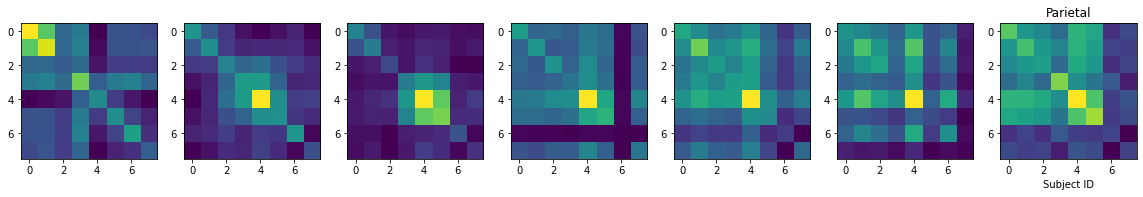

In [23]:
#plt.figure(figsize=(20, 10))
#ax = plt.gca()
#im = ax.imshow(np.arange(100).reshape((10,10)))
fig, ax = plt.subplots(1, len(ROI_names)-1,figsize=(20,10)) # Caution, figsize will also influence positions.
for r in range(len(ROI_names)-1):
    im1 = ax[r].imshow(corr_mat[:,:,r])

    #plt.subplot(1, len(ROI_names)-1, r+1)
    
    #plt.imshow(
    #    corr_mat[:,:,r]
    #)
    
    plt.title(ROI_names[r+1])
    plt.xlabel('Subject ID')
    
#fig.colorbar(im1, ax=ax[r])


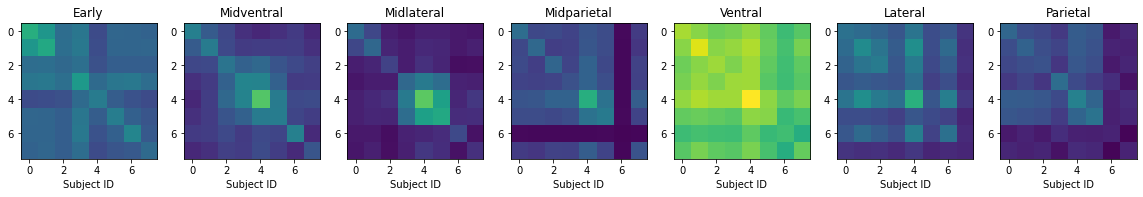

In [26]:
plt.figure(figsize=(20, 10))

for r in range(len(ROI_names)-1):
    
    plt.subplot(1, len(ROI_names)-1, r+1)
    
    plt.imshow(
        corr_mat[:,:,r]
    )
    
    plt.clim(0,.6)
    plt.title(ROI_names[r+1])
    plt.xlabel('Subject ID')

plt.savefig('../../../results/figures/RSMcorr_acrossSubj_voxThresh' + str(int(thresh*100)) + '_upto60corr_zscore.png')
